# Setup

In [1]:
!pip install scikit-optimize

     |████████████████████████████████| 101 kB 4.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from skopt import gp_minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, precision_recall_curve, confusion_matrix
import seaborn as sns
import sklearn.tree as tree
from IPython.display import Image
import pydotplus
import itertools as it
import os
import joblib
plt.style.use("seaborn-whitegrid")

## Important parameters

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/"

## Loading datasets

In [ ]:
df = pd.read_csv(PATH + "datasets/train.csv")
test = pd.read_csv(PATH + "datasets/test.csv")
submission_sample = pd.read_csv(PATH + "datasets/submission_sample.csv")
metadata = pd.read_csv(PATH + "datasets/metadata.csv")
metadata.columns = ["cod", "type"]
num_dis = metadata[metadata.type == "Quantitativo discreto"].cod.to_list()
num_dis.remove("y")
num_con = metadata[metadata.type == "Quantitativo continua"].cod.to_list()
cat_nom = metadata[metadata.type == "Qualitativo nominal"].cod.to_list()
cat_nom.remove("id")
cat_ord = metadata[metadata.type == "Qualitativo ordinal"].cod.to_list() 
y = df["y"]
test_id = test["id"]
test.drop(["id"], axis=1, inplace=True)
X = df.drop(["id", "y"], axis=1)

# Analysis

In [ ]:
X.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68
0,18,19,2853,29442,1386,2435,35,-999,3,63,6498,1166,2007,26,13,11,11,4,1547,26,2068,1,3,-1.047096,1.373163,7,-0.766413,24,4,2,0,16,3,44,463,27,2,0,4,0.625059,3,25,6,0.393785,4.072330,3.458537,3.530519,-0.217553,-0.723658,-0.417345,-0.241944,1.238036,-0.847455,-0.72722,-0.159764,-1.137766,1.491969,-0.551234,-1.451562,0.903744,-0.935822,-0.313932,-0.626021,-0.252854,-0.057058,0.205969,-0.609478,-0.718463
1,4,110,1986,13684,7189,-999,-999,17,3,63,13989,497,2289,16,1,3,3,3,1797,16,2417,5,1,1.137429,-0.787236,6,1.304779,4,2,1,0,14,0,1,532,2,1,0,4,0.206912,3,30,3,-2.539457,-0.300906,-0.275879,-0.185221,-0.217553,-0.723658,-0.417345,-0.241944,-0.451196,-0.847455,-0.72722,0.563245,-0.580149,-0.044488,-0.312472,0.274405,-0.237315,-0.198672,-0.038823,-0.022451,-0.506560,-0.079581,-0.047908,-0.487158,-1.310430
2,0,39,1019,10232,678,791,16,-999,3,63,9739,562,641,10,34,34,10,4,511,10,664,5,3,1.137429,-0.787236,7,-0.766413,3,4,1,0,11,1,3,81,26,3,0,4,-0.629381,3,23,5,0.393785,-0.300906,-0.275879,-0.185221,-0.217553,-0.723658,-0.417345,-0.241944,-1.065463,-0.847455,-0.72722,-0.503284,-0.889936,0.381089,-0.696629,-0.036618,-0.237315,-0.507718,-0.408436,0.861348,-0.548274,-0.079581,-0.047908,1.469962,1.123214
3,20,39,1751,2689,8235,1042,13,10,1,14,2890,6541,811,8,59,60,23,5,624,8,839,0,0,-1.047096,-1.507369,1,1.304779,19,1,2,0,8,0,11,414,27,0,0,4,0.834132,3,22,10,0.393785,0.792403,0.968926,-0.185221,1.833518,1.381868,-0.417345,-0.241944,0.777336,-0.847455,-0.72722,-0.341499,0.750308,-0.639043,0.713966,1.183440,-0.237315,0.601231,-0.533435,0.736323,-0.272686,1.227625,-0.154567,-0.487158,-0.850011
4,7,44,2262,29428,6031,304,16,-999,3,63,13541,7238,260,10,55,56,20,5,1413,10,270,2,3,1.137429,-0.787236,8,1.304779,3,4,1,0,17,4,3,567,8,3,2,4,-0.211235,3,26,5,0.393785,-0.300906,-0.275879,-0.185221,-0.217553,1.381868,-0.417345,-0.241944,-0.527980,-0.847455,-0.72722,0.303199,0.358997,-0.639043,0.226176,-0.261625,-0.975946,-0.322263,-0.258716,0.542318,-0.430653,-0.079581,-0.047908,2.081562,-0.850011


## Quantitativo discreto

In [ ]:
X[num_dis]

,var24,var25,var27,var40,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var67,var68
0,0,4,0,9,1,4,3,1,0,0,0,0,42,1,1,0.132353,0.139706
1,2,1,1,7,0,0,0,0,0,0,0,0,20,1,1,0.147059,0.106618
2,2,1,0,3,1,0,0,0,0,0,0,0,12,1,1,0.382353,0.242647
3,0,0,1,10,1,1,1,0,1,1,0,0,36,1,1,0.147059,0.132353
4,2,1,1,5,1,0,0,0,0,1,0,0,19,1,1,0.455882,0.132353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14118,2,1,0,2,1,0,0,0,0,0,0,0,25,2,2,0.455882,0.147059
14119,1,2,0,10,1,0,0,0,0,0,1,0,-999,0,0,0.147059,0.198529
14120,2,1,0,1,1,0,0,0,0,0,0,0,16,2,2,0.397059,0.158088
14121,0,0,0,1,1,0,0,0,0,1,0,1,21,2,2,0.264706,0.128676


Notes

* Var 67 and 68 need to be factorized

In [ ]:
X["var67"], _ = X["var67"].factorize()
X["var68"], _ = X["var68"].factorize()

## Qualitativo nominal

In [ ]:
X[cat_nom]

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var28,var29,var30,var31,var33,var34,var35,var36,var37,var38,var39,var41
0,18,19,2853,29442,1386,2435,35,-999,3,63,6498,1166,2007,26,13,11,11,4,1547,26,2068,1,3,24,4,2,0,3,44,463,27,2,0,4,3
1,4,110,1986,13684,7189,-999,-999,17,3,63,13989,497,2289,16,1,3,3,3,1797,16,2417,5,1,4,2,1,0,0,1,532,2,1,0,4,3
2,0,39,1019,10232,678,791,16,-999,3,63,9739,562,641,10,34,34,10,4,511,10,664,5,3,3,4,1,0,1,3,81,26,3,0,4,3
3,20,39,1751,2689,8235,1042,13,10,1,14,2890,6541,811,8,59,60,23,5,624,8,839,0,0,19,1,2,0,0,11,414,27,0,0,4,3
4,7,44,2262,29428,6031,304,16,-999,3,63,13541,7238,260,10,55,56,20,5,1413,10,270,2,3,3,4,1,0,4,3,567,8,3,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14118,4,39,2511,28766,1109,2094,31,24,3,-999,5082,-999,1678,23,55,56,20,5,198,23,1739,5,4,26,5,1,0,5,12,314,0,1,0,4,3
14119,19,129,1114,-999,6376,-999,-999,27,-999,-999,-999,-999,1387,13,-999,-999,-999,-999,719,13,1445,5,1,24,4,1,0,6,25,532,27,1,0,4,1
14120,27,44,1786,23761,9048,623,35,27,3,14,1249,882,358,26,34,34,10,4,482,26,380,5,3,24,4,1,0,3,44,362,2,0,0,4,3
14121,4,89,210,19593,3634,2453,35,27,1,63,21128,3849,2033,26,55,56,20,5,1573,26,2093,3,3,24,4,2,0,2,24,553,0,18,0,4,3


## Qualitativo ordinal

In [ ]:
X[cat_ord]

,var26,var32,var42,var43
0,7,16,25,6
1,6,14,30,3
2,7,11,23,5
3,1,8,22,10
4,8,17,26,5
...,...,...,...,...
14118,7,17,23,5
14119,-999,13,26,13
14120,7,17,25,4
14121,7,16,28,14


## Quantitativo continuo

In [ ]:
X[num_con]

,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66
0,0.212414,0.137,0.833333,0.037822,0.058070,0.311441,0.142303,0.056146,0.632694,0.024054,0.253356,0.00603
1,0.228784,0.308,0.305376,0.069325,0.248909,-999.000000,-999.000000,0.070991,0.773966,0.019315,-999.000000,-999.00000
2,0.204636,0.213,0.451613,0.018639,0.214520,-999.000000,0.200814,0.051046,0.980827,0.018536,-999.000000,-999.00000
3,0.208299,0.716,0.101075,0.204753,0.349421,-999.000000,0.352379,0.044301,0.951564,0.023684,0.363370,0.00201
4,0.222896,0.596,0.101075,0.140394,0.189641,0.021226,0.226161,0.059125,0.906155,0.020733,-999.000000,-999.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
14118,0.227307,0.048,0.978495,0.063199,0.122448,-999.000000,0.069347,0.036178,0.869828,0.016160,-999.000000,-999.00000
14119,0.210104,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,0.295418,0.055899,0.921292,0.018293,-999.000000,-999.00000
14120,0.217944,0.029,1.000000,0.034263,0.207001,-999.000000,0.203394,0.040697,0.930373,0.009440,-999.000000,-999.00000
14121,0.209336,0.154,0.833333,0.022503,0.200405,0.070788,0.381038,0.100384,0.680121,0.041096,-999.000000,-999.00000


# Mutual information

In [ ]:
for col in num_con+num_dis:
  X[col].replace(-999, np.nan, inplace=True)
  median = X[col].dropna().median()
  if median == np.nan:
    median = 0
  X.loc[X[col].isna(), col] = median
  X[col]= (X[col] - np.mean(X[col]))/np.std(X[col])


In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
mi_scores = make_mi_scores(X, y, X.dtypes == int)
mi_scores

var4     0.495512
var11    0.465069
var5     0.306347
var12    0.214074
var6     0.115142
           ...   
var50    0.000000
var65    0.000000
var49    0.000000
var48    0.000000
var60    0.000000
Name: MI Scores, Length: 68, dtype: float64

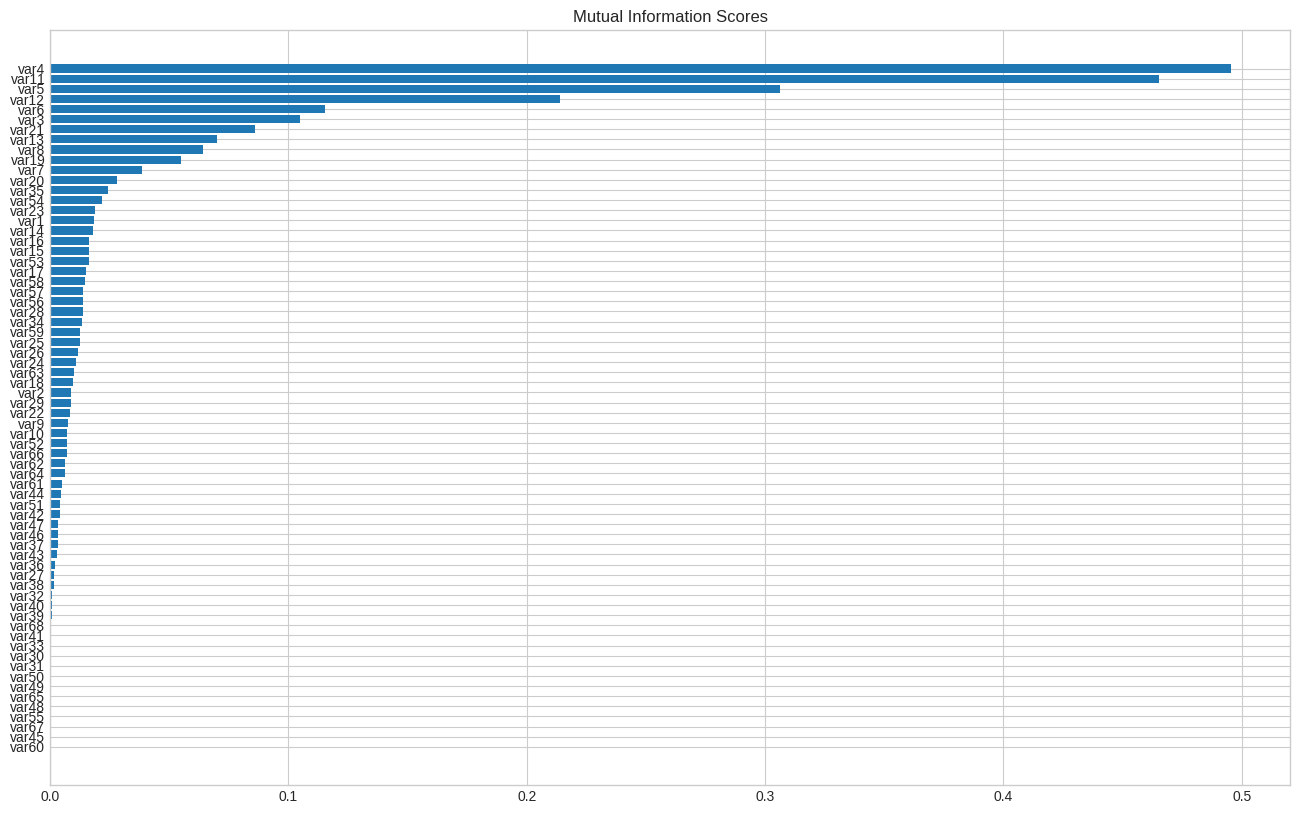

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(16, 10))
plot_mi_scores(mi_scores)

In [ ]:
mi_scores[num_con].sort_values(ascending=False)

var58    0.014775
var57    0.013873
var56    0.013748
var59    0.012712
var63    0.010033
var66    0.007015
var62    0.006434
var64    0.006322
var61    0.004876
var65    0.000000
var60    0.000000
var55    0.000000
Name: MI Scores, dtype: float64

# K-means Clustering

In [ ]:
X["y"] = y.to_numpy()
X.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
0,18,19,2853,29442,1386,2435,35,-999,3,63,6498,1166,2007,26,13,11,11,4,1547,26,2068,1,3,0,4,7,0,24,4,2,0,16,3,44,463,27,2,0,4,9,3,25,6,1,4,3,1,0,0,0,0,42,1,1,0.212414,0.137,0.833333,0.037822,0.058070,0.311441,0.142303,0.056146,0.632694,0.024054,0.253356,0.00603,0.132353,0.139706,1
1,4,110,1986,13684,7189,-999,-999,17,3,63,13989,497,2289,16,1,3,3,3,1797,16,2417,5,1,2,1,6,1,4,2,1,0,14,0,1,532,2,1,0,4,7,3,30,3,0,0,0,0,0,0,0,0,20,1,1,0.228784,0.308,0.305376,0.069325,0.248909,-999.000000,-999.000000,0.070991,0.773966,0.019315,-999.000000,-999.00000,0.147059,0.106618,0
2,0,39,1019,10232,678,791,16,-999,3,63,9739,562,641,10,34,34,10,4,511,10,664,5,3,2,1,7,0,3,4,1,0,11,1,3,81,26,3,0,4,3,3,23,5,1,0,0,0,0,0,0,0,12,1,1,0.204636,0.213,0.451613,0.018639,0.214520,-999.000000,0.200814,0.051046,0.980827,0.018536,-999.000000,-999.00000,0.382353,0.242647,0
3,20,39,1751,2689,8235,1042,13,10,1,14,2890,6541,811,8,59,60,23,5,624,8,839,0,0,0,0,1,1,19,1,2,0,8,0,11,414,27,0,0,4,10,3,22,10,1,1,1,0,1,1,0,0,36,1,1,0.208299,0.716,0.101075,0.204753,0.349421,-999.000000,0.352379,0.044301,0.951564,0.023684,0.363370,0.00201,0.147059,0.132353,0
4,7,44,2262,29428,6031,304,16,-999,3,63,13541,7238,260,10,55,56,20,5,1413,10,270,2,3,2,1,8,1,3,4,1,0,17,4,3,567,8,3,2,4,5,3,26,5,1,0,0,0,0,1,0,0,19,1,1,0.222896,0.596,0.101075,0.140394,0.189641,0.021226,0.226161,0.059125,0.906155,0.020733,-999.000000,-999.00000,0.455882,0.132353,1


In [ ]:
kmeans = KMeans(n_clusters=6)
cluster = X[num_con + ["y"]].copy()
cluster["Cluster"] = kmeans.fit_predict(cluster)
cluster["Cluster"] = cluster["Cluster"].astype("category")
cluster.head()

,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,y,Cluster
0,0.212414,0.137,0.833333,0.037822,0.058070,0.311441,0.142303,0.056146,0.632694,0.024054,0.253356,0.00603,1,3
1,0.228784,0.308,0.305376,0.069325,0.248909,-999.000000,-999.000000,0.070991,0.773966,0.019315,-999.000000,-999.00000,0,1
2,0.204636,0.213,0.451613,0.018639,0.214520,-999.000000,0.200814,0.051046,0.980827,0.018536,-999.000000,-999.00000,0,1
3,0.208299,0.716,0.101075,0.204753,0.349421,-999.000000,0.352379,0.044301,0.951564,0.023684,0.363370,0.00201,0,5
4,0.222896,0.596,0.101075,0.140394,0.189641,0.021226,0.226161,0.059125,0.906155,0.020733,-999.000000,-999.00000,1,0


In [ ]:
cluster[["Cluster", "y"]].groupby("Cluster").mean().std()["y"]

0.0540563072843487

In [ ]:
def tune_kmeans(params):
  n_clusters, max_iter, n_init, tol = params

  cluster = X[["var27", "var50"]+ ["y"]].copy()
  kmeans = KMeans(n_clusters=n_clusters, 
                  max_iter=max_iter, 
                  tol=tol, n_init=n_init, 
                  n_jobs=-1, 
                  random_state=42)
  cluster["Cluster"] = kmeans.fit_predict(cluster)
  cluster["Cluster"] = cluster["Cluster"].astype("category")
  print(params)
  print()

  return -cluster[["Cluster", "y"]].groupby("Cluster").mean().std()["y"]

In [ ]:
space = [(2, 20),
         (200, 1000),
         (2, 20),
         (1e-5, 1e-3, 'log-uniform')]


res = gp_minimize(tune_kmeans, space, random_state=42, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


[16, 347, 16, 0.0001562069367563987]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3639
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 2 started. Evaluating function at random point.
[10, 280, 10, 4.649617447336329e-05]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1590
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 3 started. Evaluating function at random point.
[5, 721, 3, 0.0002779697551526683]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0510
Function value obtained: -0.4024
Current minimum: -0.5345
Iteration No: 4 started. Evaluating function at random point.


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


[19, 201, 20, 0.00017177621112338383]

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4611
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 5 started. Evaluating function at random point.
[13, 206, 2, 0.00011208547084229366]

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0764
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 6 started. Evaluating function at random point.


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


[9, 237, 20, 2.9210748185657167e-05]

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.2823
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 7 started. Evaluating function at random point.
[4, 695, 9, 0.0009256818992066885]

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.0979
Function value obtained: -0.0662
Current minimum: -0.5345
Iteration No: 8 started. Evaluating function at random point.


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


[10, 888, 14, 7.961566078062952e-05]

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.2469
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 9 started. Evaluating function at random point.
[2, 954, 12, 5.899741796710488e-05]

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.0852
Function value obtained: -0.0740
Current minimum: -0.5345
Iteration No: 10 started. Evaluating function at random point.
[2, 385, 6, 0.00023255572624036796]

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.4924
Function value obtained: -0.0740
Current minimum: -0.5345
Iteration No: 11 started. Searching for the next optimal point.
[6, 833, 3, 9.058046653324325e-05]

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.5670
Function value obtained: -0.4886
Current minimum: -0.5345
Iteration No: 12 started. Searching for the next optimal point.


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


[18, 250, 18, 0.00018741028748456648]

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.8715
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 13 started. Searching for the next optimal point.
[14, 292, 8, 9.425869332778106e-05]



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.5959
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 14 started. Searching for the next optimal point.
[15, 227, 5, 0.0008588635838073339]



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5398
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 15 started. Searching for the next optimal point.


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


[12, 980, 20, 2.528544320387776e-05]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.7434
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 16 started. Searching for the next optimal point.
[20, 998, 4, 1.390643165032847e-05]



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.7484
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 17 started. Searching for the next optimal point.
[20, 200, 2, 0.001]



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.7299
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 18 started. Searching for the next optimal point.
[15, 200, 2, 1e-05]



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.6879
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 19 started. Searching for the next optimal point.
[17, 1000, 2, 1e-05]



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.5917
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 20 started. Searching for the next optimal point.
[8, 857, 2, 0.0009102111546336521]

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5754
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 21 started. Searching for the next optimal point.
[11, 200, 2, 0.001]



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.7921
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 22 started. Searching for the next optimal point.
[7, 223, 19, 2.8264712393283696e-05]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.8869
Function value obtained: -0.5189
Current minimum: -0.5345
Iteration No: 23 started. Searching for the next optimal point.


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


[17, 200, 20, 0.001]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.1869
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 24 started. Searching for the next optimal point.
[8, 200, 20, 1e-05]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.9869
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 25 started. Searching for the next optimal point.


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


[11, 1000, 20, 1e-05]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.0404
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 26 started. Searching for the next optimal point.


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


[13, 1000, 20, 1e-05]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.9880
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 27 started. Searching for the next optimal point.
[20, 1000, 2, 0.001]



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.8336
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 28 started. Searching for the next optimal point.
[20, 1000, 2, 1e-05]



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.7459
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 29 started. Searching for the next optimal point.
[20, 1000, 2, 1e-05]



/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.7625
Function value obtained: -0.5345
Current minimum: -0.5345
Iteration No: 30 started. Searching for the next optimal point.
[20, 1000, 2, 0.001]



/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7647
Function value obtained: -0.5345
Current minimum: -0.5345


In [ ]:
kmeans = KMeans(n_clusters=5, 
                  max_iter=240, 
                  tol=1e-03, 
                  n_init=20, 
                  n_jobs=-1, 
                  random_state=42)
cluster = X[num_con + ["y"]].copy()
cluster["Cluster"] = kmeans.fit_predict(cluster)
cluster["Cluster"] = cluster["Cluster"].astype("category")
cluster.head()

,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,y,Cluster
0,-0.159764,-1.137766,1.491969,-0.551234,-1.451562,0.903744,-0.935822,-0.313932,-0.626021,-0.252854,-0.057058,0.205969,1,0
1,0.563245,-0.580149,-0.044488,-0.312472,0.274405,-0.237315,-0.198672,-0.038823,-0.022451,-0.506560,-0.079581,-0.047908,0,0
2,-0.503284,-0.889936,0.381089,-0.696629,-0.036618,-0.237315,-0.507718,-0.408436,0.861348,-0.548274,-0.079581,-0.047908,0,0
3,-0.341499,0.750308,-0.639043,0.713966,1.183440,-0.237315,0.601231,-0.533435,0.736323,-0.272686,1.227625,-0.154567,0,2
4,0.303199,0.358997,-0.639043,0.226176,-0.261625,-0.975946,-0.322263,-0.258716,0.542318,-0.430653,-0.079581,-0.047908,1,2


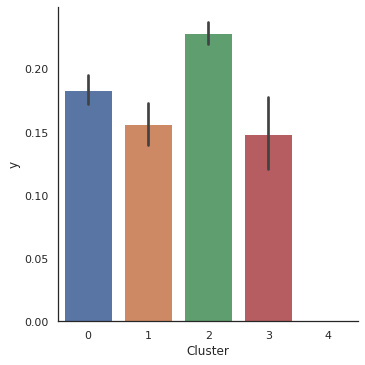

In [ ]:
sns.set_theme(style="white")
sns.catplot(
    data=cluster, kind="bar",
    x="Cluster", y="y")

In [ ]:
def viz_tree(df, lf, add_features=[]):
  dt_feature_names = df.columns
  dt_target_names = 'y'
  tree.export_graphviz(lf, out_file='tree.dot', 
                         feature_names=dt_feature_names, class_names=["0","1"],
                         filled=True)  
  graph = pydotplus.graph_from_dot_file('tree.dot')
  return (graph.create_png())

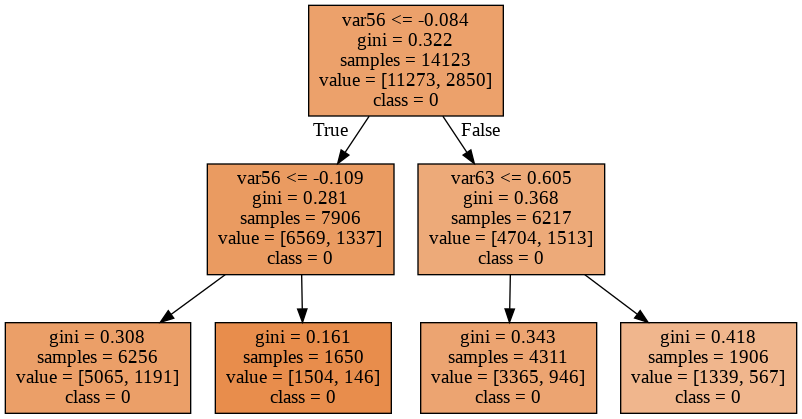

In [ ]:
cluster_ = cluster.drop("y", axis=1)
lf = tree.DecisionTreeClassifier(max_depth=2)
lf.fit(cluster_, y)
Image(viz_tree(cluster_, lf))

In [ ]:
for col in num_con+num_dis:
  X[col].replace(-999, np.nan, inplace=True)
  median = X[col].dropna().median()
  if median == np.nan:
    median = 0
  X.loc[X[col].isna(), col] = median
  X[col]= (X[col] - np.mean(X[col]))/np.std(X[col])

In [ ]:
def evaluate(y_pred, y_true, plot_matrix=True):
    score = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    if plot_matrix:
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.matshow(conf_matrix, cmap=plt.cm.gray)
        plt.show()
    return score, f1

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, thrh):
    plt.figure(figsize=(8, 4))
    plt.axis([0, 1.1, 0, 1])
    precision_by_thrs = precisions[np.argmax(thresholds == thrh)]
    recall_by_thrs = recalls[np.argmax(thresholds == thrh)]
    
    plt.plot([thrh, thrh], [0., precision_by_thrs], "r:")
    plt.plot([thrh, thrh], [0., recall_by_thrs], "r:")
    plt.plot([0, thrh], [precision_by_thrs, precision_by_thrs], "r:")
    plt.plot([0, thrh], [recall_by_thrs, recall_by_thrs], "r:")
    plt.plot([thrh], [precision_by_thrs], "ro")        
    plt.plot([thrh], [recall_by_thrs], "ro")   
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")    
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=14)
    plt.xlabel("Threshold")
    plt.ylabel("Value")
    plt.grid(True)
    
def better_threshold(precisions, recalls, thresholds):
    f1_best = 0
    threshold = 0
    for i in range(len(precisions)):
        if precisions[i] != 0 and recalls[i] != 0:
            f1 = 2*(precisions[i]*recalls[i])/(precisions[i] + recalls[i])
        else:
            f1 = 0
        if f1 > f1_best:
            f1_best = f1
            threshold = thresholds[i]
            
    
    return threshold, f1_best

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
space = [(2, 20),
         (200, 1000),
         (2, 20),
         (1e-5, 1e-3, 'log-uniform')]


parameters_cluster = { }
for cols in list(it.combinations(num_con+num_dis, 2)):

  def tune_kmeans_(params):
    n_clusters, max_iter, n_init, tol = params

    kmeans = KMeans(n_clusters=n_clusters, 
                    max_iter=max_iter, 
                    tol=tol, n_init=n_init, 
                    n_jobs=-1, 
                    random_state=42)
    cluster = df_copy.copy()
    cluster["Cluster"] = kmeans.fit_predict(cluster, ytrain)
    cluster["Cluster"] = cluster["Cluster"].astype("category")
    print(params)
    print()

    cluster["y"] = ytrain.to_numpy()
    return -cluster[["Cluster", "y"]].groupby("Cluster").mean().std()["y"]
  
  lf = tree.DecisionTreeClassifier(max_depth=2)
  if cols[0] == cols[1]:
      continue

  df_copy = Xtrain[list(cols)].copy()
  res = gp_minimize(tune_kmeans_, space, random_state=42, verbose=1, n_calls=30)

  name_col = cols[0] + "_" + cols[1]

  n_clusters, max_iter, n_init, tol = res.x
  kmeans = KMeans(n_clusters=n_clusters, 
                    max_iter=max_iter, 
                    tol=tol, n_init=n_init, 
                    n_jobs=-1, 
                    random_state=42)
  
  df_copy[name_col] = kmeans.fit_predict(df_copy, ytrain)
  df_copy_ = df_copy[name_col].astype("category")

  df_copy = Xtrain[num_con+num_dis].copy()
  df_copy[name_col] = df_copy_.to_numpy()
  lf.fit(df_copy, ytrain)


  test_copy = Xtest[list(cols)].copy()
  test_copy[name_col] = kmeans.predict(test_copy)
  test_copy_ = test_copy[name_col].astype("category")

  test_copy = Xtest[num_con+num_dis].copy()
  test_copy[name_col] = test_copy_.to_numpy()

  y_pred = lf.predict_proba(test_copy)[:, 1]
  precisions, recalls, thresholds = precision_recall_curve(ytest, y_pred)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  y_pred = (y_pred >= thrs).astype(int)
  _, metric = evaluate(y_pred, ytest, plot_matrix=False)

  with open("{}trees/kmeans/{}_{}.png".format(PATH, name_col, metric), "wb") as png:
    png.write(viz_tree(test_copy, lf))
  parameters_cluster[name_col] = [res.x, metric]

Iteration No: 1 started. Evaluating function at random point.
[16, 347, 16, 0.0001562069367563987]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2721
Function value obtained: -0.0720
Current minimum: -0.0720
Iteration No: 2 started. Evaluating function at random point.
[10, 280, 10, 4.649617447336329e-05]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1306
Function value obtained: -0.0579
Current minimum: -0.0720
Iteration No: 3 started. Evaluating function at random point.
[5, 721, 3, 0.0002779697551526683]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0460
Function value obtained: -0.0684
Current minimum: -0.0720
Iteration No: 4 started. Evaluating function at random point.
[19, 201, 20, 0.00017177621112338383]

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3605
Function value obtained: -0.0689
Current minimum: -0.0720
Iteration No: 5 started. Evaluating function at random point.
[13, 20

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.5787
Function value obtained: -0.0896
Current minimum: -0.0896
Iteration No: 14 started. Searching for the next optimal point.
[2, 200, 20, 0.001]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4522
Function value obtained: -0.0896
Current minimum: -0.0896
Iteration No: 15 started. Searching for the next optimal point.
[2, 993, 4, 0.0008705214538478238]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3732
Function value obtained: -0.0896
Current minimum: -0.0896
Iteration No: 16 started. Searching for the next optimal point.
[20, 998, 4, 1.390682827445745e-05]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4260
Function value obtained: -0.0717
Current minimum: -0.0896
Iteration No: 17 started. Searching for the next optimal point.
[2, 225, 19, 0.0008754311109411768]

Iteration No: 17 ended. Search fi

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4902
Function value obtained: -0.0896
Current minimum: -0.0896
Iteration No: 30 started. Searching for the next optimal point.
[2, 976, 2, 0.0009202183737999275]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4528
Function value obtained: -0.0896
Current minimum: -0.0896
Iteration No: 1 started. Evaluating function at random point.
[16, 347, 16, 0.0001562069367563987]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2681
Function value obtained: -0.0612
Current minimum: -0.0612
Iteration No: 2 started. Evaluating function at random point.
[10, 280, 10, 4.649617447336329e-05]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1131
Function value obtained: -0.0607
Current minimum: -0.0612
Iteration No: 3 started. Evaluating function at random point.
[5, 721, 3, 0.0002779697551526683]

Iteration No: 3 ended. Evaluation done at rand

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5143
Function value obtained: -0.1107
Current minimum: -0.1107
Iteration No: 27 started. Searching for the next optimal point.
[2, 948, 2, 0.0005738812471673992]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4209
Function value obtained: -0.1107
Current minimum: -0.1107
Iteration No: 28 started. Searching for the next optimal point.
[2, 209, 18, 0.0009415991320013736]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4935
Function value obtained: -0.1107
Current minimum: -0.1107
Iteration No: 29 started. Searching for the next optimal point.
[2, 200, 2, 1e-05]



/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5546
Function value obtained: -0.1107
Current minimum: -0.1107
Iteration No: 30 started. Searching for the next optimal point.
[2, 976, 2, 0.0009202183737999275]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4647
Function value obtained: -0.1107
Current minimum: -0.1107
Iteration No: 1 started. Evaluating function at random point.
[16, 347, 16, 0.0001562069367563987]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2853
Function value obtained: -0.0524
Current minimum: -0.0524
Iteration No: 2 started. Evaluating function at random point.
[10, 280, 10, 4.649617447336329e-05]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1352
Function value obtained: -0.0538
Current minimum: -0.0538
Iteration No: 3 started. Evaluating function at random point.
[5, 721, 3, 0.0002779697551526683]

Iteration No: 3 ended. Evaluation done at rand

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4578
Function value obtained: -0.0800
Current minimum: -0.0800
Iteration No: 30 started. Searching for the next optimal point.
[2, 976, 2, 0.0009202183737999275]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5653
Function value obtained: -0.0800
Current minimum: -0.0800
Iteration No: 1 started. Evaluating function at random point.
[16, 347, 16, 0.0001562069367563987]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2788
Function value obtained: -0.0459
Current minimum: -0.0459
Iteration No: 2 started. Evaluating function at random point.
[10, 280, 10, 4.649617447336329e-05]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1313
Function value obtained: -0.0386
Current minimum: -0.0459
Iteration No: 3 started. Evaluating function at random point.
[5, 721, 3, 0.0002779697551526683]

Iteration No: 3 ended. Evaluation done at rand

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20, 1000, 20, 1e-05]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.8174
Function value obtained: -0.0559
Current minimum: -0.0588
Iteration No: 27 started. Searching for the next optimal point.
[20, 313, 2, 0.0009837348227436933]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4639
Function value obtained: -0.0566
Current minimum: -0.0588
Iteration No: 28 started. Searching for the next optimal point.
[15, 995, 20, 1.1443490983026636e-05]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.7308
Function value obtained: -0.0417
Current minimum: -0.0588
Iteration No: 29 started. Searching for the next optimal point.
[20, 1000, 2, 0.001]



/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4887
Function value obtained: -0.0566
Current minimum: -0.0588
Iteration No: 30 started. Searching for the next optimal point.
[18, 244, 2, 2.9241946099462106e-05]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5322
Function value obtained: -0.0530
Current minimum: -0.0588
Iteration No: 1 started. Evaluating function at random point.
[16, 347, 16, 0.0001562069367563987]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2662
Function value obtained: -0.0389
Current minimum: -0.0389
Iteration No: 2 started. Evaluating function at random point.
[10, 280, 10, 4.649617447336329e-05]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1197
Function value obtained: -0.0303
Current minimum: -0.0389
Iteration No: 3 started. Evaluating function at random point.
[5, 721, 3, 0.0002779697551526683]

Iteration No: 3 ended. Evaluation done at ra

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20, 200, 20, 0.001]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7735
Function value obtained: -0.0402
Current minimum: -0.0496
Iteration No: 27 started. Searching for the next optimal point.
[16, 262, 3, 0.0008800914524298145]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4760
Function value obtained: -0.0358
Current minimum: -0.0496
Iteration No: 28 started. Searching for the next optimal point.
[15, 995, 20, 1.1443490983026636e-05]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6770
Function value obtained: -0.0336
Current minimum: -0.0496
Iteration No: 29 started. Searching for the next optimal point.


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20, 200, 20, 1e-05]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.7606
Function value obtained: -0.0402
Current minimum: -0.0496
Iteration No: 30 started. Searching for the next optimal point.
[20, 981, 2, 1.9849680287494867e-05]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4676
Function value obtained: -0.0392
Current minimum: -0.0496
Iteration No: 1 started. Evaluating function at random point.
[16, 347, 16, 0.0001562069367563987]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7469
Function value obtained: -0.0638
Current minimum: -0.0638
Iteration No: 2 started. Evaluating function at random point.
[10, 280, 10, 4.649617447336329e-05]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4844
Function value obtained: -0.0493
Current minimum: -0.0638
Iteration No: 3 started. Evaluating function at random point.
[5, 721, 3, 0.0002779697551526683]

Iteration No: 3 ended.

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20, 200, 20, 0.001]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1.0903
Function value obtained: -0.0616
Current minimum: -0.0684
Iteration No: 15 started. Searching for the next optimal point.
[16, 879, 20, 0.0008794229048461933]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 1.2745
Function value obtained: -0.0638
Current minimum: -0.0684
Iteration No: 16 started. Searching for the next optimal point.
[20, 891, 2, 8.482483635623962e-05]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4715
Function value obtained: -0.0620
Current minimum: -0.0684
Iteration No: 17 started. Searching for the next optimal point.
[17, 840, 20, 1.100681512177804e-05]

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 1.9229
Function value obtained: -0.0620
Current minimum: -0.0684
Iteration No: 18 started. Searching for the next optimal point.
[20, 958, 2, 1.03089295441395

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20, 200, 20, 0.001]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.2278
Function value obtained: -0.0616
Current minimum: -0.0684
Iteration No: 27 started. Searching for the next optimal point.
[18, 1000, 20, 0.001]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.3036
Function value obtained: -0.0630
Current minimum: -0.0684
Iteration No: 28 started. Searching for the next optimal point.
[17, 215, 3, 0.0008662840375148557]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.7131
Function value obtained: -0.0631
Current minimum: -0.0684
Iteration No: 29 started. Searching for the next optimal point.
[18, 200, 20, 0.001]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.2247
Function value obtained: -0.0630
Current minimum: -0.0684
Iteration No: 30 started. Searching for the next optimal point.
[19, 952, 2, 1.1719395654915832e-05]

Iteration No: 30 ended

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20, 1000, 20, 1e-05]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1.5570
Function value obtained: -0.0530
Current minimum: -0.0530
Iteration No: 15 started. Searching for the next optimal point.
[15, 204, 18, 0.0009204633638758667]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.7639
Function value obtained: -0.0308
Current minimum: -0.0530
Iteration No: 16 started. Searching for the next optimal point.
[20, 213, 12, 1.0283811967075525e-05]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.2045
Function value obtained: -0.0572
Current minimum: -0.0572
Iteration No: 17 started. Searching for the next optimal point.
[20, 226, 3, 1.1106437986306926e-05]



In [ ]:
name_dictionary = f"{PATH}trees/kmeans/parameters_cluster.pkl.z"
jb.dump(parameters_cluster, name_dictionary)

In [ ]:
comb_features = jb.load(name_dictionary)

In [ ]:
list_comb = [file.split("_") for file in os.listdir(PATH + "trees/kmeans")][:-1]
list_comb = [lt[:2] + [lt[2][:-4]] for lt in list_comb]

In [ ]:
list_comb = sorted(list_comb, key= lambda x: x[2], reverse=True)
list_comb[:15]

[['var66', 'var54', '0.38648488441019563'],
 ['var65', 'var54', '0.3859230539815091'],
 ['var24', 'var50', '0.3843037974683544'],
 ['var48', 'var54', '0.38394728960766694'],
 ['var60', 'var54', '0.38321853475266127'],
 ['var64', 'var53', '0.38304990242542514'],
 ['var63', 'var54', '0.38300455235204856'],
 ['var53', 'var54', '0.38251366120218583'],
 ['var47', 'var54', '0.3824068417837508'],
 ['var45', 'var54', '0.3823529411764706'],
 ['var46', 'var54', '0.3797698364627498'],
 ['var60', 'var24', '0.37968507429585274'],
 ['var51', 'var54', '0.37957957957957955'],
 ['var44', 'var54', '0.3789026977872083'],
 ['var61', 'var54', '0.37822198842714366']]

## Analyse the clusterization

In [ ]:
for col in num_con+num_dis:
  X[col].replace(-999, np.nan, inplace=True)
  median = X[col].dropna().median()
  if median == np.nan:
    median = 0
  X.loc[X[col].isna(), col] = median
  X[col]= (X[col] - np.mean(X[col]))/np.std(X[col])

In [ ]:
X["y"] = y.to_numpy()

In [ ]:
kmeans = KMeans(n_clusters=20,
                  max_iter=1000, 
                  tol=1e-03, 
                  n_init=2, 
                  n_jobs=-1, 
                  random_state=42)
cluster = X[["var27", "var50"] + ["y"]].copy()
cluster["Cluster"] = kmeans.fit_predict(cluster)
cluster["Cluster"] = cluster["Cluster"].astype("category")
cluster

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


,var27,var50,y,Cluster
0,-0.766413,-0.417345,1,4
1,1.304779,-0.417345,0,0
2,-0.766413,-0.417345,0,1
3,1.304779,-0.417345,0,0
4,1.304779,-0.417345,1,5
...,...,...,...,...
14118,-0.766413,-0.417345,0,1
14119,-0.766413,2.396099,0,2
14120,-0.766413,-0.417345,0,1
14121,-0.766413,-0.417345,0,1


In [ ]:
cluster[["Cluster", "y"]].groupby("Cluster").sum()

,y
Cluster,
0,0
1,0
2,0
3,0
4,1417
5,1197
7,69
18,167


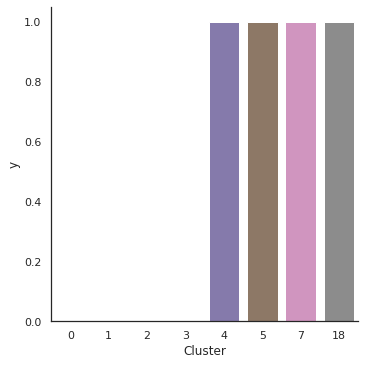

In [ ]:
sns.set_theme(style="white")
sns.catplot(
    data=cluster, kind="bar",
    x="Cluster", y="y")

## Test

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
Xtrain = Xtrain[["var27", "var50"]].copy()
Xtest = Xtest[["var27", "var50"]].copy()

In [ ]:
kmeans = KMeans(n_clusters=8,
                  max_iter=1000, 
                  tol=1e-03, 
                  n_init=2, 
                  n_jobs=-1, 
                  random_state=42)
Xtrain["Cluster"] = kmeans.fit_predict(Xtrain, ytrain)
Xtrain["Cluster"] = Xtrain["Cluster"].astype("category")

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [ ]:
Xtest["Cluster"] = kmeans.predict(Xtest)

In [ ]:
Xtest.head()

,var27,var50,Cluster
13347,1,0,0
3855,1,1,3
4590,0,0,6
9942,0,0,6
1121,0,0,6


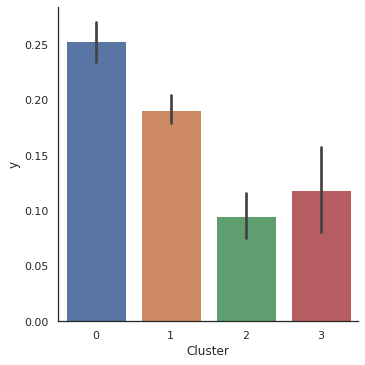

In [ ]:
cluster = Xtrain.copy()
cluster["y"] = ytrain.to_numpy()
sns.set_theme(style="white")
sns.catplot(
    data=cluster, kind="bar",
    x="Cluster", y="y")

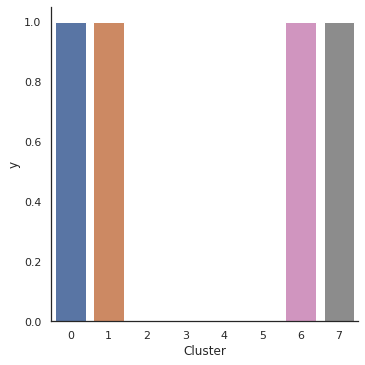

In [ ]:
sns.set_theme(style="white")
sns.catplot(
    data=Xtest, kind="bar",
    x="Cluster", y="y")